# Exploring the Weather Data Set of the Nairobi Ambulance Challenge <a name="Top"></a>
***
In this notebook we will look further into the Weather_Nairobi_Daily_GFS.csv data set.

## Table of Contents

[Imports and setup](#Imports_setup)<br>
[Extract, transform and load the data](#ETL)<br>
[Data cleaning](#Data_cleaning)<br>
[Feature engineering](#Feature_engineering)<br>
[Data analysis](#Data_analysis)<br>
[Scaling and PCA](#Scaling_PCA)<br>
[Prediction](#Prediction)<br>
[Classifcation of good and bad weather days](#Classifying_good_bad_weather)<br>

</br>
</br>
</br>

***
## Imports and setup <a name="Imports_setup"></a>

### Importing packages

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import holidays
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

import sys  
sys.path.insert(0, '../Scripts')
import capstone_functions as cf

### Setup

In [2]:
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.3f}'.format

### Functions

In [3]:
def clean_weather_data(df_weather):
    '''
    Fills the missing information by looking at the previous and the following existing values
    and then incrementaly distributing the difference over the missing days.
    This guarantees a smooth development of the weather data over time.
    '''
    
    missing = df_weather[pd.isnull(df_weather).any(1)].index
    
    if len(missing) > 0:
        for col in df_weather.columns[1:]:
            before = df_weather.loc[missing[0]-1, col]
            after = df_weather.loc[missing[-1]+1, col]
            diff = after - before
            for i in range(len(missing)):
                df_weather.loc[missing[i], col] = before+diff/(len(missing)+1)*(i+1)
                
    return df_weather



def add_weather_change(df_weather):
    df_weather["change_water_atmosphere"] = 0
    df_weather["change_temperature"] = 0
    for row in range(df_weather.shape[0]):
        if row == 0:
            df_weather.loc[row, "change_water_atmosphere"] = 0
            df_weather.loc[row, "change_temperature"] = 0
        else:
            df_weather.loc[row, "change_water_atmosphere"] = df_weather.loc[row, "precipitable_water_entire_atmosphere"] - df_weather.loc[row-1, "precipitable_water_entire_atmosphere"]
            df_weather.loc[row, "change_temperature"] = df_weather.loc[row, "temperature_2m_above_ground"] - df_weather.loc[row-1, "temperature_2m_above_ground"]
    return df_weather



def join_accident_to_weather(df_accident, df_weather):
    '''
    Left-joins the accident data to the weather data, resulting in a dataframe containing the weather information
    for every day as well as the aggregated accidents.
    '''
    
    # Count accidents per day and leftjoin to weather dataframe
    df_accident["date"] = df_accident["datetime"].apply(lambda x: x.date())
    if type(df_weather.loc[0, "Date"]) is not dt.date:
        df_weather["Date"] = df_weather["Date"].apply(lambda x: x.date())
    accident_count = df_accident.groupby("date").count()["uid"].reset_index()
    df_combined = df_weather.merge(accident_count[["date", "uid"]], left_on="Date", right_on="date", how='left')
    
    # Fill NaNs with zeros
    df_combined.fillna(value=0, inplace=True)
        
    # Drop duplicate Date column
    df_combined.drop("date", axis=1, inplace=True)
    
    # Rename column
    df_combined.rename(columns={"Date":"date", "uid":"accidents"}, inplace=True)
    
    # Adding column with 1 for sundays and holidays, 0 for working days
    df_combined["sun_holiday"] = df_combined["date"].apply(lambda x: 1 if (x.weekday() == 6) or (x in holidays.Kenya()) else 0)
    
    # Change type to integer
    df_combined["accidents"] = df_combined["accidents"].astype("int")
    
    return df_combined



def scale_pca_weather(df_combined):
    '''
    Scaling and analysing the principal components of the weather data.
    '''
    
    # Scaling
    mm_scaler = MinMaxScaler()
    X_mm = df_combined[["precipitable_water_entire_atmosphere", "relative_humidity_2m_above_ground",
                        "specific_humidity_2m_above_ground", "temperature_2m_above_ground"]]
    X_mm_scaled = mm_scaler.fit_transform(X_mm)

    std_scaler = StandardScaler()
    X_std = df_combined[["u_component_of_wind_10m_above_ground", "v_component_of_wind_10m_above_ground",
                         "change_water_atmosphere", "change_temperature"]]
    X_std_scaled = std_scaler.fit_transform(X_std)

    X_scaled = pd.DataFrame(np.concatenate((X_mm_scaled, X_std_scaled), axis=1), columns=["precipitable_water_entire_atmosphere", "relative_humidity_2m_above_ground",
                              "specific_humidity_2m_above_ground", "temperature_2m_above_ground", "u_component_of_wind_10m_above_ground", "v_component_of_wind_10m_above_ground",
                               "change_water_atmosphere", "change_temperature"])
    
    # Principal componant analysis (PCA)
    pca = PCA(n_components=0.99)
    pca_decomposition = pca.fit(X_scaled)
    X_pca = pca_decomposition.transform(X_scaled)
    df_combined_pca = pd.DataFrame(X_pca)
    df_combined_pca = df_combined_pca.join(df_combined[["date", "accidents", "sun_holiday"]])
    
    return df_combined_pca



def split_combined(df_combined_pca):
    X_train = df_combined_pca[df_combined_pca["date"] < dt.date(2019, 7, 1)][[0, 1, 2, 3, 4, "sun_holiday"]]
    y_train = df_combined_pca[df_combined_pca["date"] < dt.date(2019, 7, 1)]["accidents"]
    X_test = df_combined_pca[(df_combined_pca["date"] >= dt.date(2019, 7, 1)) & (df_combined_pca["date"] < dt.date(2020, 1, 1))][[0, 1, 2, 3, 4, "sun_holiday"]]
    
    return X_train, X_test, y_train



def predict_poly(X_train, X_test, y_train):
    poly = PolynomialFeatures(degree=4)
    X_train_poly = poly.fit_transform(X_train.drop("sun_holiday", axis=1))
    lin_poly = LinearRegression()
    lin_poly.fit(X_train_poly, y_train)
    X_test_poly = poly.transform(X_test.drop("sun_holiday", axis=1))

    return lin_poly.predict(X_test_poly)
    


def predict_accidents_on_weather(df_accident, df_weather):
    '''
    Takes the raw data and returns the number of predicted road traffic accidents for every day in the second half of 2019.
    '''
    
    df_weather = clean_weather_data(df_weather)
    df_weather = add_weather_change(df_weather)
    df_combined = join_accident_to_weather(df_accident, df_weather)
    df_combined_pca = scale_pca_weather(df_combined)
    X_train, X_test, y_train = split_combined(df_combined_pca)
    y_pred = predict_poly(X_train, X_test, y_train)
    y_pred = [0 if i < 0 else i for i in y_pred]
    return y_pred



def clean_expand_train(df_train):
    '''
    Expands the accident data by splitting the datetime information to single values.
    Days of the week, weekends and holidays are identified.
    Additionally, time windows according to the Zindi challenge are added.
    '''
    
    df_train["date"] = df_train["datetime"].apply(lambda x: x.date())
    df_train["time"] = df_train["datetime"].apply(lambda x: x.time())
    df_train["day"] = df_train["datetime"].apply(lambda x: x.day)
    df_train["weekday"] = df_train["datetime"].apply(lambda x: x.weekday())
    df_train["weekend"] = df_train["weekday"].apply(lambda x: 1 if x>4 else 0)
    
    dict_months = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
                   7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}
    df_train["month"] = df_train["datetime"].apply(lambda x: dict_months.get(x.month))
    df_train["year"] = df_train["datetime"].apply(lambda x: x.year)
    df_train["holiday"] = df_train["date"].apply(lambda x: 1 if (x in holidays.Kenya()) else 0)
    
    dict_windows = {1: "00-03", 2: "03-06", 3: "06-09", 4: "09-12", 5: "12-15", 6: "15-18", 7: "18-21", 8: "21-24"}
    df_train["time_window"] = df_train["datetime"].apply(lambda x: math.floor(x.hour / 3) + 1)
    df_train["time_window"] = df_train["time_window"].apply(lambda x: dict_windows.get(x))
    df_train["datetime_window"] = df_train[["date", "time_window"]].apply(lambda x : f"{x[0]}_{x[1]}", axis=1)
    
    return df_train



def create_time_windows(df_train):
    '''
    Creates a complete list of 3-hour-time-windows covering the time frame of the accident data set.
    The accidents are the added to the respective time windows. The location information is aggregated
    to various indicators, describing the spread of accident locations per time window.
    '''
    
    # Preparing df_train
    df_train["date"] = df_train["datetime"].apply(lambda x: x.date())
    dict_windows = {1: "00-03", 2: "03-06", 3: "06-09", 4: "09-12", 5: "12-15", 6: "15-18", 7: "18-21", 8: "21-24"}
    df_train["time_window"] = df_train["datetime"].apply(lambda x: math.floor(x.hour / 3) + 1)
    df_train["time_window"] = df_train["time_window"].apply(lambda x: dict_windows.get(x))
    df_train["datetime_window"] = df_train[["date", "time_window"]].apply(lambda x : f"{x[0]}_{x[1]}", axis=1)
    
    # Creating empty time windows
    date_list = pd.date_range(df_train["date"].min(), periods=546).tolist()
    window_list = ["00-03", "03-06", "06-09", "09-12", "12-15", "15-18", "18-21", "21-24"]
    datetime_window_list = []
    for day in date_list:
        for time_window in window_list:
            datetime_window_list.append(str(day.date()) + "_" + time_window)
    
    # Creating dataframe from window_list
    df_complete = pd.DataFrame(datetime_window_list, columns=["datetime_window"])

    # Counting accidents per time window and leftjoin to complete dataframe
    acc_count = df_train.groupby("datetime_window").count()["uid"].reset_index()
    df_complete = df_complete.merge(acc_count[["datetime_window", "uid"]], on="datetime_window", how='left')
    df_complete.rename(columns={"uid":"accidents"}, inplace=True)
    
    # Creating new data frame with split value columns
    new = df_complete["datetime_window"].str.split("_", n=1, expand=True)
    
    # Adding date column to complete dataframe from new data frame
    df_complete["date"]= new[0].astype('datetime64[ns]')
    
    # Adding time_window column to complete dataframe from new data frame
    df_complete["time_window"]= new[1]
    
    # Adding day of month
    df_complete["day"] = df_complete["date"].apply(lambda x: x.day)
    
    # Adding weekday
    df_complete["weekday"] = df_complete["date"].apply(lambda x: x.weekday())
    
    # Adding 1 for weekend days and 0 for working days
    df_complete["weekend"] = df_complete["weekday"].apply(lambda x: 1 if x>4 else 0)
    
    # Adding month
    dict_months = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
                   7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}
    df_complete["month"] = df_complete["date"].apply(lambda x: dict_months.get(x.month))
    
    # Adding year
    df_complete["year"] = df_complete["date"].apply(lambda x: x.year)
    
    # Adding holidays
    df_complete["holiday"] = df_complete["date"].apply(lambda x: 1 if (x in holidays.Kenya()) else 0)
    
    # Adding rainy / flood season (https://en.wikipedia.org/wiki/Nairobi#Climate)
    rainy_season = ["Mar", "Apr", "May", "Oct", "Nov", "Dec"]
    df_complete["rainy_season"] = df_complete["month"].apply(lambda x: 1 if (x in rainy_season) else 0)
    
    # Adding min for latitude and longitude
    l_min = df_train.groupby("datetime_window")[["latitude", "longitude"]].min().reset_index()
    df_complete = df_complete.merge(l_min[["datetime_window", "latitude", "longitude"]], on="datetime_window", how='left')
    df_complete.rename(columns={"latitude":"latitude_min", "longitude":"longitude_min"}, inplace=True)
    
    # Adding max for latitude and longitude
    l_max = df_train.groupby("datetime_window")[["latitude", "longitude"]].max().reset_index()
    df_complete = df_complete.merge(l_max[["datetime_window", "latitude", "longitude"]], on="datetime_window", how='left')
    df_complete.rename(columns={"latitude":"latitude_max", "longitude":"longitude_max"}, inplace=True)
    
    # Adding spread for latitude and longitude
    df_complete["latitude_spread"] = df_complete["latitude_max"] - df_complete["latitude_min"]
    df_complete["longitude_spread"] = df_complete["longitude_max"] - df_complete["longitude_min"]
    
    # Adding median for latitude and longitude
    l_median = df_train.groupby("datetime_window")[["latitude", "longitude"]].median().reset_index()
    df_complete = df_complete.merge(l_median[["datetime_window", "latitude", "longitude"]], on="datetime_window", how='left')
    df_complete.rename(columns={"latitude":"latitude_median", "longitude":"longitude_median"}, inplace=True)
    
    # Adding mean for latitude and longitude
    l_mean = df_train.groupby("datetime_window")[["latitude", "longitude"]].mean().reset_index()
    df_complete = df_complete.merge(l_mean[["datetime_window", "latitude", "longitude"]], on="datetime_window", how='left')
    df_complete.rename(columns={"latitude":"latitude_mean", "longitude":"longitude_mean"}, inplace=True)
    
    # Adding standard deviation for latitude and longitude
    l_std = df_train.groupby("datetime_window")[["latitude", "longitude"]].std().reset_index()
    df_complete = df_complete.merge(l_std[["datetime_window", "latitude", "longitude"]], on="datetime_window", how='left')
    df_complete.rename(columns={"latitude":"latitude_std", "longitude":"longitude_std"}, inplace=True)
    
    # Filling NaNs with zeros
    df_complete.fillna(value=0, inplace=True)
    
    # Changing type to integer
    df_complete["accidents"] = df_complete["accidents"].astype("int")
    
    return df_complete



def print_results():
    results = X_test.copy()
    results['y_test'] = y_test
    results2 = X_test2.copy()
    results2['y_pred'] = y_pred2
    results3 = df_combined_pca.merge(results, on=[0, 1, 2, 3, 4], how='left').merge(results2, on=[0, 1, 2, 3, 4], how='left')

    fig, ax = plt.subplots(figsize=(16, 8))
    chart = sns.barplot(x="date", y="accidents", data=results3, label="Observed", color="b");
    chart = sns.barplot(x="date", y="y_pred", data=results3, label="Predicted", color="r", alpha=0.6);
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

[Back to top](#Top)<br>

</br>
</br>
</br>

## Extract, transform and load the data <a name="ETL"></a>

Importing the weather data.

In [4]:
df_weather = pd.read_csv('../Inputs/Weather_Nairobi_Daily_GFS.csv', parse_dates=['Date'])
print(df_weather.shape)
df_weather.head()

(731, 7)


,Date,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground
0,2018-01-01,24.100,72.700,0.010,15.161,-0.012,-0.934
1,2018-01-02,27.362,74.900,0.010,16.048,0.315,-0.485
2,2018-01-03,30.247,86.600,0.012,15.839,-0.283,-0.654
3,2018-01-04,33.011,90.900,0.013,16.169,0.212,0.908
4,2018-01-05,27.250,82.413,0.011,15.923,1.047,-0.038


In [5]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Date                                  731 non-null    datetime64[ns]
 1   precipitable_water_entire_atmosphere  728 non-null    float64       
 2   relative_humidity_2m_above_ground     728 non-null    float64       
 3   specific_humidity_2m_above_ground     728 non-null    float64       
 4   temperature_2m_above_ground           728 non-null    float64       
 5   u_component_of_wind_10m_above_ground  728 non-null    float64       
 6   v_component_of_wind_10m_above_ground  728 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 40.1 KB


In [6]:
df_weather.describe().T

,count,mean,std,min,25%,50%,75%,max
precipitable_water_entire_atmosphere,728.000,23.977,4.693,10.800,20.700,24.025,27.500,34.000
relative_humidity_2m_above_ground,728.000,83.160,9.085,42.200,79.888,85.627,89.600,95.769
specific_humidity_2m_above_ground,728.000,0.011,0.001,0.006,0.010,0.011,0.012,0.013
temperature_2m_above_ground,728.000,15.176,1.127,11.750,14.431,15.231,15.916,19.928
u_component_of_wind_10m_above_ground,728.000,-1.907,1.251,-5.880,-2.736,-1.953,-1.168,3.478
v_component_of_wind_10m_above_ground,728.000,-1.128,1.119,-3.797,-1.979,-1.084,-0.274,1.973


Importing the accident data from train.csv

In [7]:
df_train = pd.read_csv('../Inputs/Train.csv', parse_dates=['datetime'])
print(df_train.shape)
df_train.head()

(6318, 4)


,uid,datetime,latitude,longitude
0,1,2018-01-01 00:25:46,-1.189,36.931
1,2,2018-01-01 02:02:39,-0.663,37.209
2,3,2018-01-01 02:31:49,-0.663,37.209
3,4,2018-01-01 03:04:01,-1.288,36.827
4,5,2018-01-01 03:58:49,-1.189,36.931


[Back to top](#Top)<br>

</br>
</br>
</br>

## Data cleaning <a name="Data_cleaning"></a>

In [8]:
missing_bool = pd.isnull(df_weather).any(1)
df_weather[missing_bool]

,Date,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground
74,2018-03-16,nan,nan,nan,nan,nan,nan
75,2018-03-17,nan,nan,nan,nan,nan,nan
76,2018-03-18,nan,nan,nan,nan,nan,nan


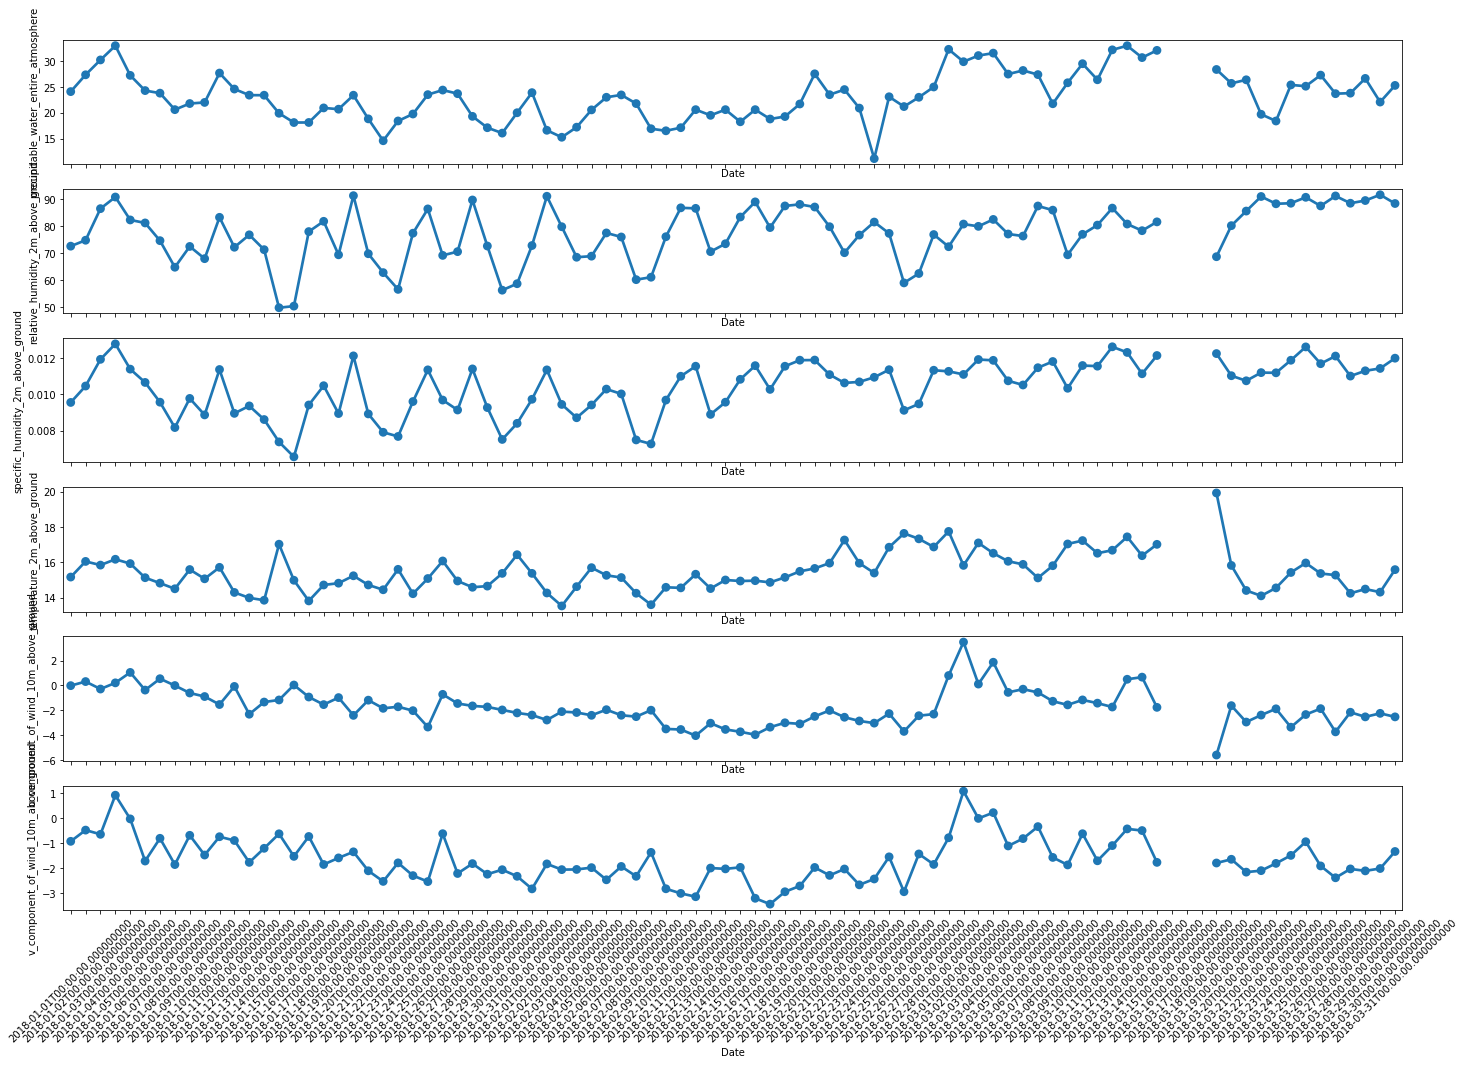

In [9]:
quarter = df_weather[(df_weather["Date"] >= "2018-01-01") & (df_weather["Date"] <= "2018-03-31")]

fig, ax = plt.subplots(6, 1, sharex=True, figsize=(24, 16))
for col in range(len(quarter.columns)-1):
    chart = sns.pointplot(ax=ax[col], x=quarter["Date"], y=quarter[quarter.columns[col+1]]);
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

In [10]:
df_weather = clean_weather_data(df_weather)

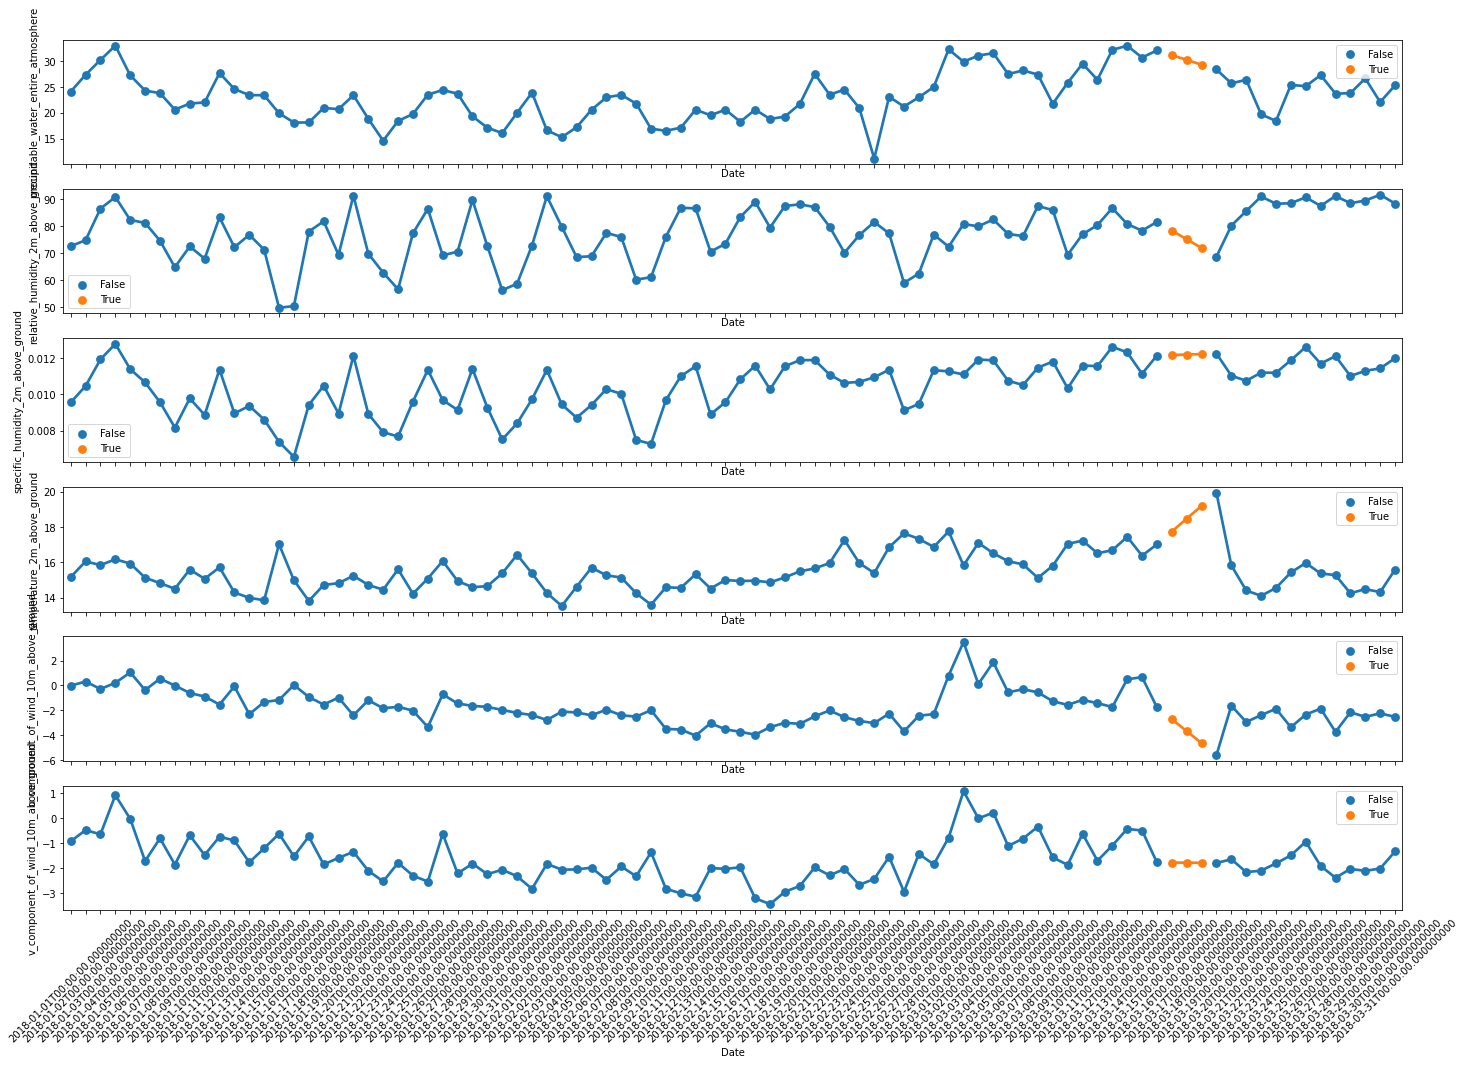

In [11]:
quarter = df_weather[(df_weather["Date"] >= "2018-01-01") & (df_weather["Date"] <= "2018-03-31")]

fig, ax = plt.subplots(6, 1, sharex=True, figsize=(24, 16))
for col in range(len(quarter.columns)-1):
    chart = sns.pointplot(ax=ax[col], x=quarter["Date"], y=quarter[quarter.columns[col+1]], hue=missing_bool);
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

[Back to top](#Top)<br>

</br>
</br>
</br>

## Feature engineering <a name="Feature_engineering"></a>

Joining the weather data to the accident data on date column.

In [12]:
df_train["date"] = df_train["datetime"].apply(lambda x: x.date())
df_weather["Date"] = df_weather["Date"].apply(lambda x: x.date())

df_weather = add_weather_change(df_weather)

df_train = df_train.merge(df_weather, left_on="date", right_on="Date", how="left")
df_train = df_train.drop("Date", axis=1)

df_train.head()

,uid,datetime,latitude,longitude,date,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,change_water_atmosphere,change_temperature
0,1,2018-01-01 00:25:46,-1.189,36.931,2018-01-01,24.100,72.700,0.010,15.161,-0.012,-0.934,0.000,0.000
1,2,2018-01-01 02:02:39,-0.663,37.209,2018-01-01,24.100,72.700,0.010,15.161,-0.012,-0.934,0.000,0.000
2,3,2018-01-01 02:31:49,-0.663,37.209,2018-01-01,24.100,72.700,0.010,15.161,-0.012,-0.934,0.000,0.000
3,4,2018-01-01 03:04:01,-1.288,36.827,2018-01-01,24.100,72.700,0.010,15.161,-0.012,-0.934,0.000,0.000
4,5,2018-01-01 03:58:49,-1.189,36.931,2018-01-01,24.100,72.700,0.010,15.161,-0.012,-0.934,0.000,0.000


Joining the weather data to the complete time window data with aggregated accidents.

In [13]:
df_train_complete = create_time_windows(df_train)
df_train_complete["date"] = df_train_complete["date"].apply(lambda x: x.date())

df_train_complete = df_train_complete.merge(df_weather, left_on="date", right_on="Date", how="left")
df_train_complete = df_train_complete.drop("Date", axis=1)

df_train_complete.head()

,datetime_window,accidents,date,time_window,day,weekday,weekend,month,year,holiday,...,latitude_std,longitude_std,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,change_water_atmosphere,change_temperature
0,2018-01-01_00-03,3,2018-01-01,00-03,1,0,0,Jan,2018,1,...,0.304,0.160,24.100,72.700,0.010,15.161,-0.012,-0.934,0.000,0.000
1,2018-01-01_03-06,4,2018-01-01,03-06,1,0,0,Jan,2018,1,...,0.281,0.162,24.100,72.700,0.010,15.161,-0.012,-0.934,0.000,0.000
2,2018-01-01_06-09,1,2018-01-01,06-09,1,0,0,Jan,2018,1,...,0.000,0.000,24.100,72.700,0.010,15.161,-0.012,-0.934,0.000,0.000
3,2018-01-01_09-12,4,2018-01-01,09-12,1,0,0,Jan,2018,1,...,0.088,0.087,24.100,72.700,0.010,15.161,-0.012,-0.934,0.000,0.000
4,2018-01-01_12-15,1,2018-01-01,12-15,1,0,0,Jan,2018,1,...,0.000,0.000,24.100,72.700,0.010,15.161,-0.012,-0.934,0.000,0.000


[Back to top](#Top)<br>

</br>
</br>
</br>

## Data analysis <a name="Data_analysis"></a>

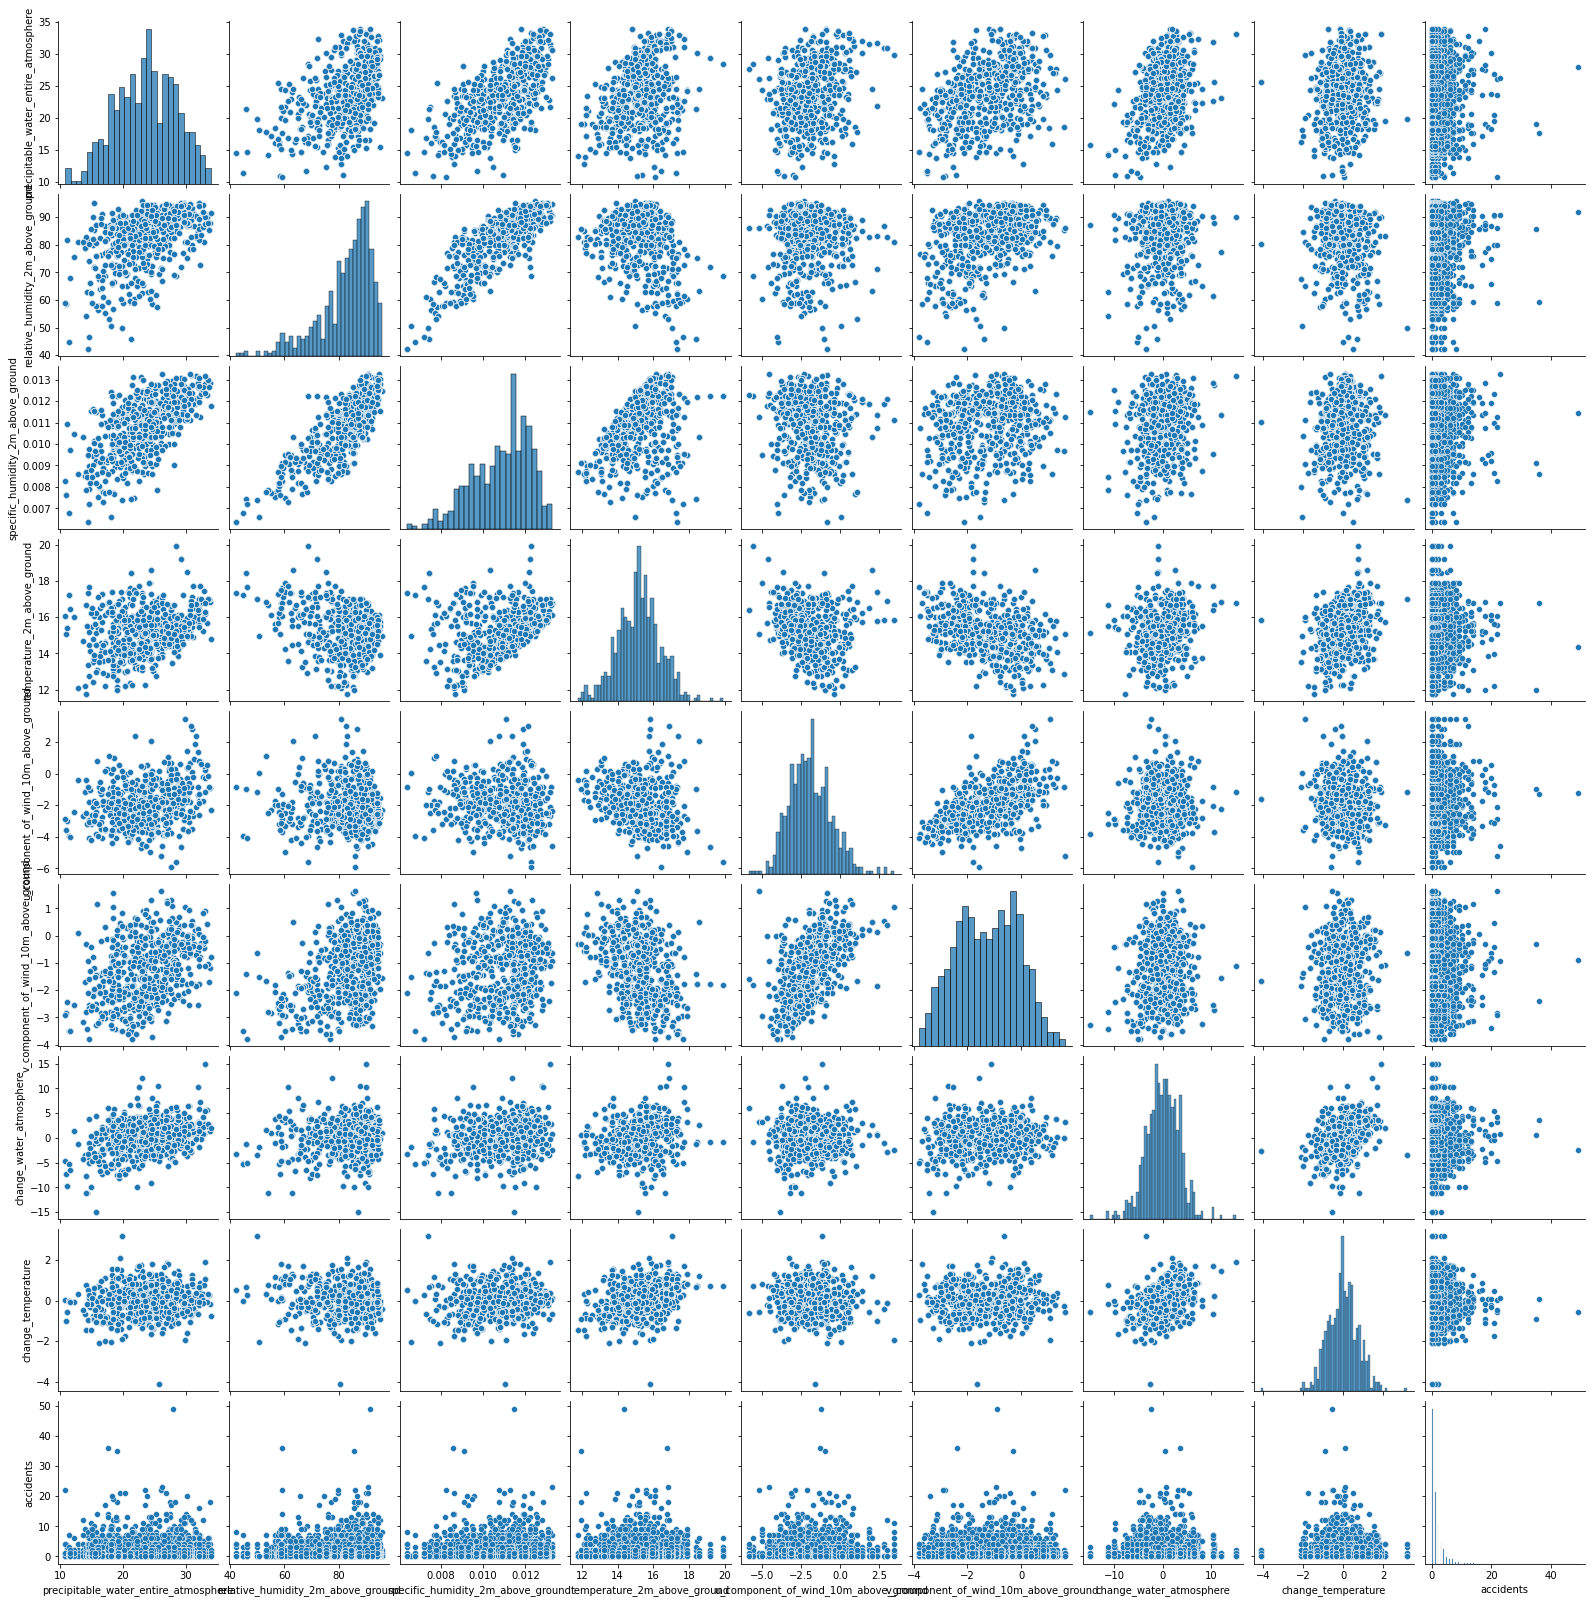

In [14]:
weather_accidents = df_train_complete[["precipitable_water_entire_atmosphere", "relative_humidity_2m_above_ground",
                                       "specific_humidity_2m_above_ground", "temperature_2m_above_ground",
                                       "u_component_of_wind_10m_above_ground", "v_component_of_wind_10m_above_ground",
                                       "change_water_atmosphere", "change_temperature", "accidents"]]
chart = sns.pairplot(weather_accidents);

In [15]:
weather_accidents.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4368 entries, 0 to 4367
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   precipitable_water_entire_atmosphere  4368 non-null   float64
 1   relative_humidity_2m_above_ground     4368 non-null   float64
 2   specific_humidity_2m_above_ground     4368 non-null   float64
 3   temperature_2m_above_ground           4368 non-null   float64
 4   u_component_of_wind_10m_above_ground  4368 non-null   float64
 5   v_component_of_wind_10m_above_ground  4368 non-null   float64
 6   change_water_atmosphere               4368 non-null   float64
 7   change_temperature                    4368 non-null   float64
 8   accidents                             4368 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 341.2 KB


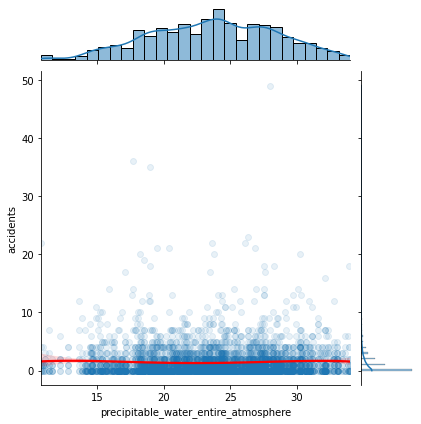

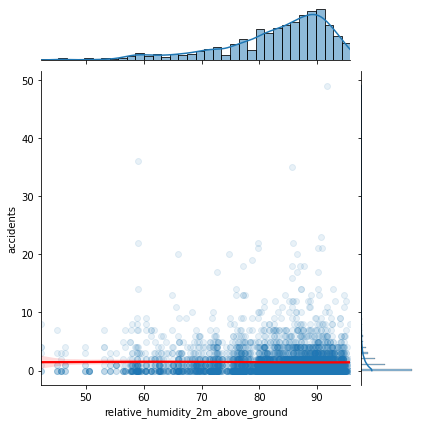

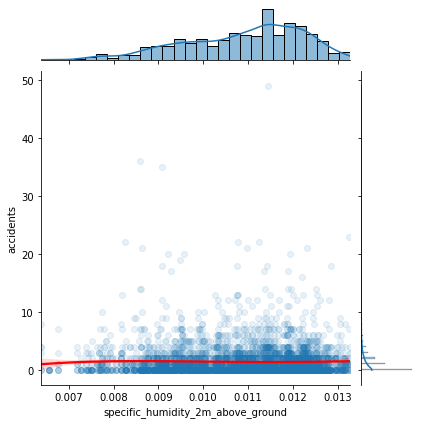

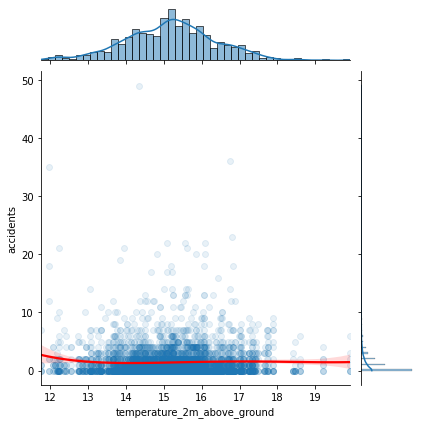

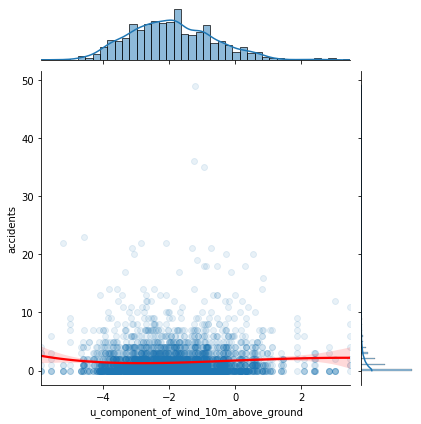

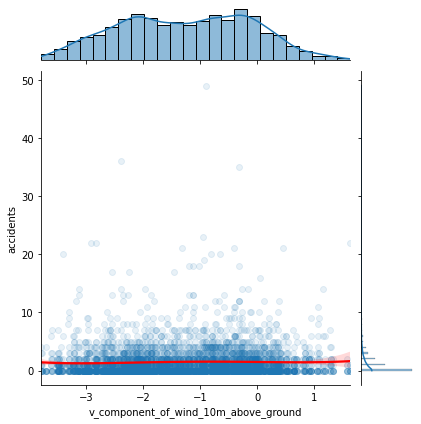

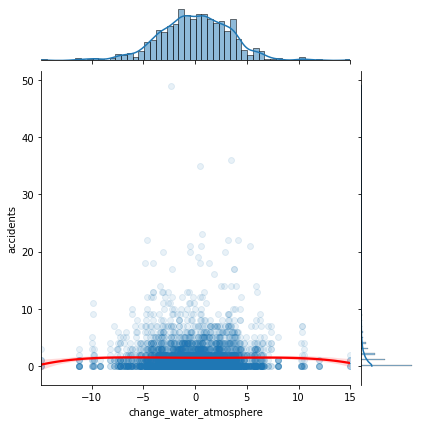

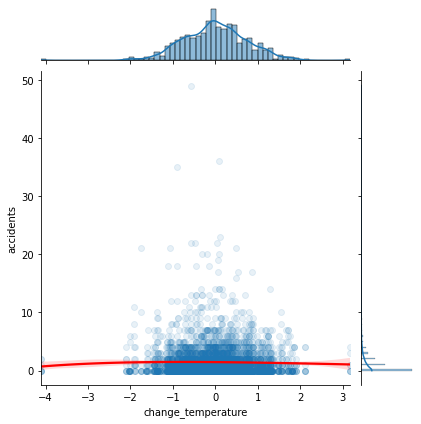

In [16]:
for col in weather_accidents.columns[:-1]:
    sns.jointplot(x=weather_accidents[col], y=weather_accidents["accidents"], kind="reg", order=4,
                  joint_kws={"line_kws":{"color":"r"}, "scatter_kws":{"alpha":0.1}});

[Back to top](#Top)<br>

</br>
</br>
</br>

## Scaling and PCA <a name="Scaling_PCA"></a>

### Scaling

In [17]:
df_combined = join_accident_to_weather(df_train, df_weather)
df_combined.head()

,date,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,change_water_atmosphere,change_temperature,accidents,sun_holiday
0,2018-01-01,24.100,72.700,0.010,15.161,-0.012,-0.934,0.000,0.000,13,1
1,2018-01-02,27.362,74.900,0.010,16.048,0.315,-0.485,3.262,0.887,27,0
2,2018-01-03,30.247,86.600,0.012,15.839,-0.283,-0.654,2.884,-0.209,43,0
3,2018-01-04,33.011,90.900,0.013,16.169,0.212,0.908,2.764,0.331,13,0
4,2018-01-05,27.250,82.413,0.011,15.923,1.047,-0.038,-5.760,-0.246,13,0


In [18]:
mm_scaler = MinMaxScaler()
X_mm = df_combined[["precipitable_water_entire_atmosphere", "relative_humidity_2m_above_ground",
                    "specific_humidity_2m_above_ground", "temperature_2m_above_ground"]]
X_mm_scaled = mm_scaler.fit_transform(X_mm)

std_scaler = StandardScaler()
X_std = df_combined[["u_component_of_wind_10m_above_ground", "v_component_of_wind_10m_above_ground",
                     "change_water_atmosphere", "change_temperature"]]
X_std_scaled = std_scaler.fit_transform(X_std)

X_scaled = pd.DataFrame(np.concatenate((X_mm_scaled, X_std_scaled), axis=1), columns=["precipitable_water_entire_atmosphere", "relative_humidity_2m_above_ground",
                          "specific_humidity_2m_above_ground", "temperature_2m_above_ground", "u_component_of_wind_10m_above_ground", "v_component_of_wind_10m_above_ground",
                           "change_water_atmosphere", "change_temperature"])
X_scaled.head()

,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,change_water_atmosphere,change_temperature
0,0.573,0.569,0.461,0.417,1.518,0.176,0.003,0.001
1,0.714,0.610,0.591,0.526,1.778,0.578,0.975,1.164
2,0.838,0.829,0.804,0.500,1.302,0.427,0.862,-0.274
3,0.957,0.909,0.927,0.540,1.696,1.827,0.826,0.435
4,0.709,0.751,0.726,0.510,2.363,0.979,-1.712,-0.322


### Principle component analysis

In [19]:
pca = PCA(n_components=0.99)
pca_decomposition = pca.fit(X_scaled)

In [20]:
i = 0
for pca_component in pca_decomposition.explained_variance_ratio_:
    if pca_component > 0.01:
        print("Component", i, "explains", round(pca_component * 100, 2), "%")
        i += 1

Component 0 explains 36.33 %
Component 1 explains 34.5 %
Component 2 explains 14.38 %
Component 3 explains 12.28 %
Component 4 explains 1.75 %


Text(0, 0.5, 'Explained variance ratio')

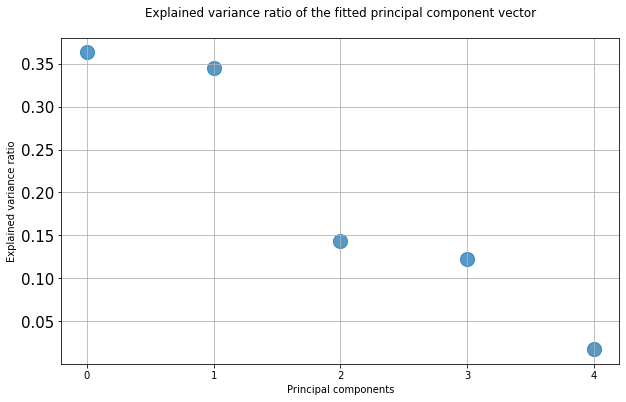

In [21]:
plt.figure(figsize=(10,6))
plt.scatter(x=[i for i in range(len(pca_decomposition.explained_variance_ratio_))],
            y=pca_decomposition.explained_variance_ratio_, s=200, alpha=0.75)
plt.grid(True)
plt.title("Explained variance ratio of the fitted principal component vector\n")
plt.xlabel("Principal components")
plt.xticks([i for i in range(len(pca_decomposition.explained_variance_ratio_))])
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio")

In [22]:
X_pca = pca_decomposition.transform(X_scaled)
df_combined_pca = pd.DataFrame(X_pca)
df_combined_pca = df_combined_pca.join(df_combined[["date", "accidents", "sun_holiday"]])

df_combined_pca.head()

,0,1,2,3,4,date,accidents,sun_holiday
0,1.158,-0.279,-0.123,-0.970,0.165,2018-01-01,13,1
1,1.831,1.162,0.027,-1.067,0.045,2018-01-02,27,0
2,1.337,0.170,-0.841,-0.456,-0.245,2018-01-03,43,0
3,2.627,0.549,-0.069,0.036,-0.337,2018-01-04,13,0
4,2.024,-1.833,0.954,-1.069,-0.273,2018-01-05,13,0


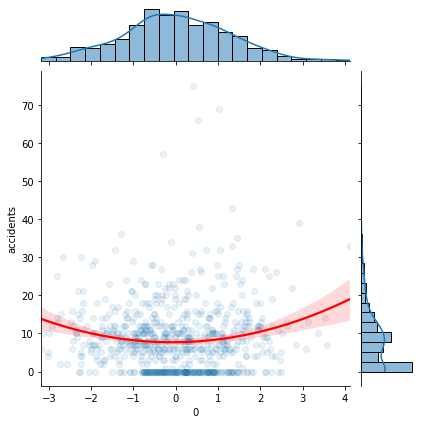

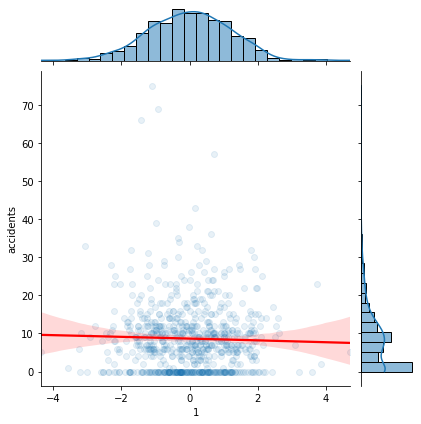

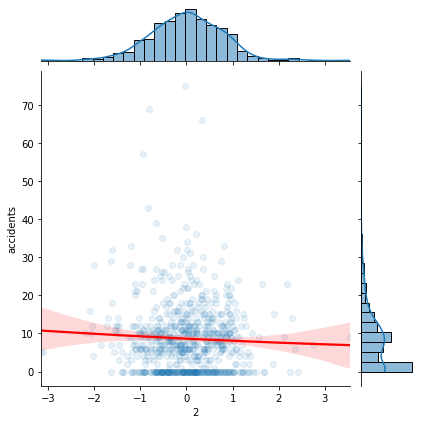

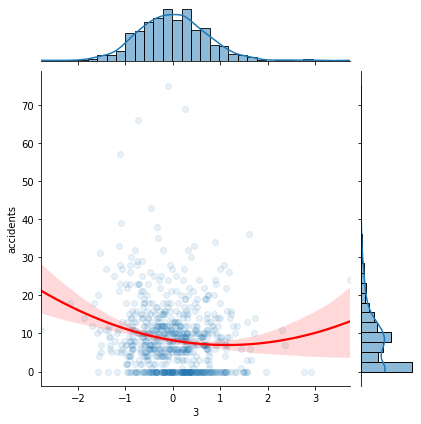

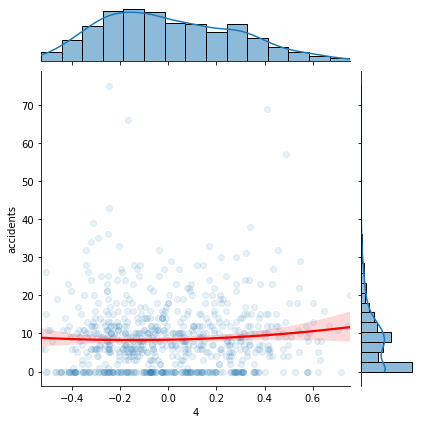

In [23]:
for col in df_combined_pca.columns[:-3]:
    sns.jointplot(x=df_combined_pca[col], y=df_combined_pca["accidents"], kind="reg", order=2,
                  joint_kws={"line_kws":{"color":"r"}, "scatter_kws":{"alpha":0.1}});

[Back to top](#Top)<br>

</br>
</br>
</br>

## Prediction <a name="Prediction"></a>

In [24]:
print(df_combined_pca.shape)
df_combined_pca.head()

(731, 8)


,0,1,2,3,4,date,accidents,sun_holiday
0,1.158,-0.279,-0.123,-0.970,0.165,2018-01-01,13,1
1,1.831,1.162,0.027,-1.067,0.045,2018-01-02,27,0
2,1.337,0.170,-0.841,-0.456,-0.245,2018-01-03,43,0
3,2.627,0.549,-0.069,0.036,-0.337,2018-01-04,13,0
4,2.024,-1.833,0.954,-1.069,-0.273,2018-01-05,13,0


### Splitting the sets

In [25]:
X_train = df_combined_pca[df_combined_pca["date"] < dt.date(2019, 7, 1)][[0, 1, 2, 3, 4, "sun_holiday"]]
y_train = df_combined_pca[df_combined_pca["date"] < dt.date(2019, 7, 1)]["accidents"]

X_test = df_combined_pca[(df_combined_pca["date"] >= dt.date(2019, 1, 1)) & (df_combined_pca["date"] < dt.date(2019, 7, 1))][[0, 1, 2, 3, 4, "sun_holiday"]]
y_test = df_combined_pca[(df_combined_pca["date"] >= dt.date(2019, 1, 1)) & (df_combined_pca["date"] < dt.date(2019, 7, 1))]["accidents"]

X_test2 = df_combined_pca[(df_combined_pca["date"] >= dt.date(2019, 1, 1)) & (df_combined_pca["date"] <= dt.date(2019, 12, 31))][[0, 1, 2, 3, 4, "sun_holiday"]]

### Linear regression

RMSE for 01/2019 - 06/2019: 7.538238257576843


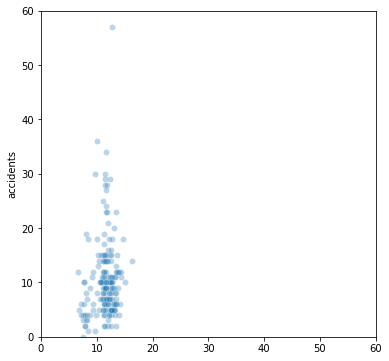

In [26]:
lin = LinearRegression()
lin.fit(X_train, y_train)

y_pred = lin.predict(X_test)
y_pred2 = lin.predict(X_test2)

print("RMSE for 01/2019 - 06/2019:", mean_squared_error(y_train[-181:], y_pred, squared=False))

fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=y_pred, y=y_test, alpha=0.3);
ax.set_xlim(0, 60);
ax.set_ylim(0, 60);

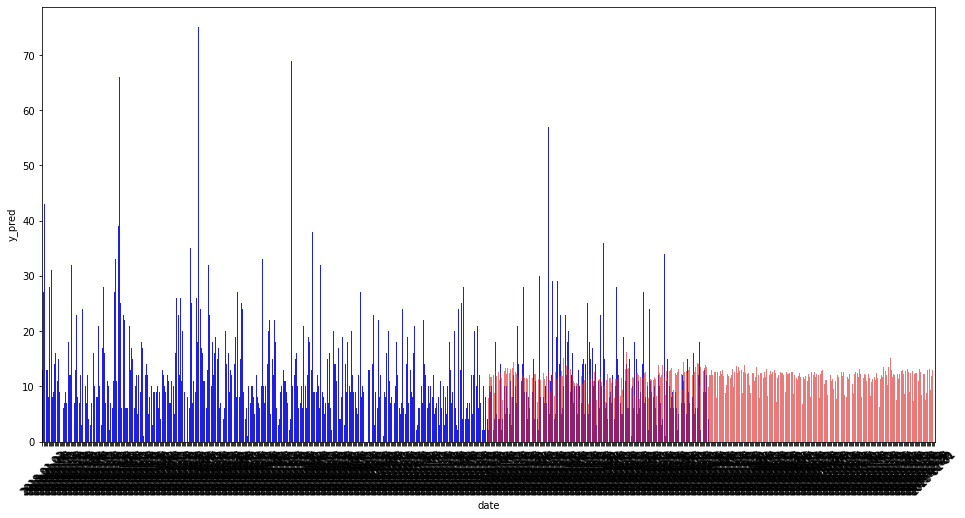

In [27]:
print_results()

### Polynomial regression

RMSE for 01/2019 - 06/2019: 7.261928943025158


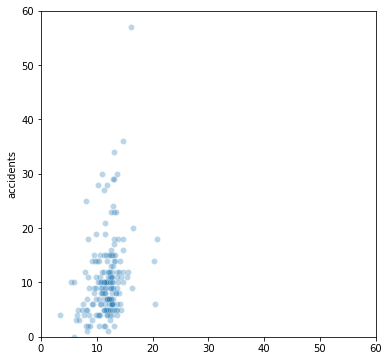

In [28]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
lin_poly = LinearRegression()
lin_poly.fit(X_train_poly, y_train)

X_test_poly = poly.transform(X_test)
X_test2_poly = poly.transform(X_test2)

y_pred = lin_poly.predict(X_test_poly)
y_pred2 = lin_poly.predict(X_test2_poly)

print("RMSE for 01/2019 - 06/2019:", mean_squared_error(y_train[-181:], y_pred, squared=False))

fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=y_pred, y=y_test, alpha=0.3);
ax.set_xlim(0, 60);
ax.set_ylim(0, 60);

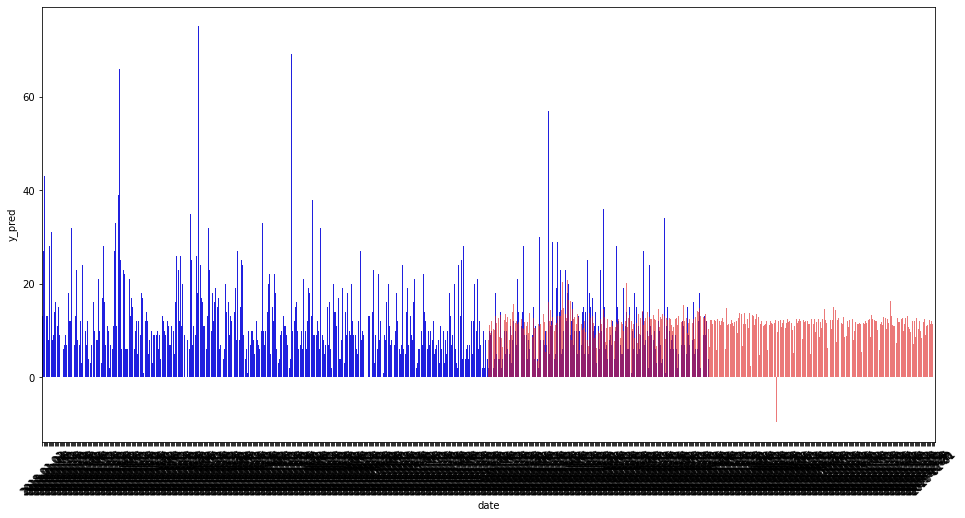

In [29]:
print_results()

### Polynomial regression - version 2 without Sundays and holidays

RMSE for 01/2019 - 06/2019: 6.614984803369288


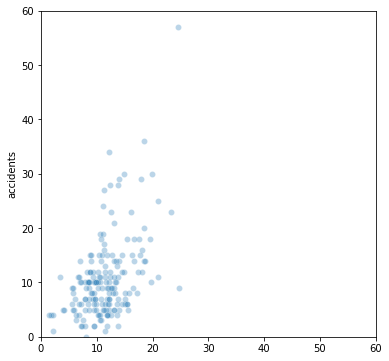

In [30]:
poly = PolynomialFeatures(degree=4)
X_train_poly = poly.fit_transform(X_train.drop("sun_holiday", axis=1))
lin_poly = LinearRegression()
lin_poly.fit(X_train_poly, y_train)

X_test_poly = poly.transform(X_test.drop("sun_holiday", axis=1))
X_test2_poly = poly.transform(X_test2.drop("sun_holiday", axis=1))

y_pred = lin_poly.predict(X_test_poly)
y_pred2 = lin_poly.predict(X_test2_poly)

print("RMSE for 01/2019 - 06/2019:", mean_squared_error(y_train[-181:], y_pred, squared=False))

fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=y_pred, y=y_test, alpha=0.3);
ax.set_xlim(0, 60);
ax.set_ylim(0, 60);

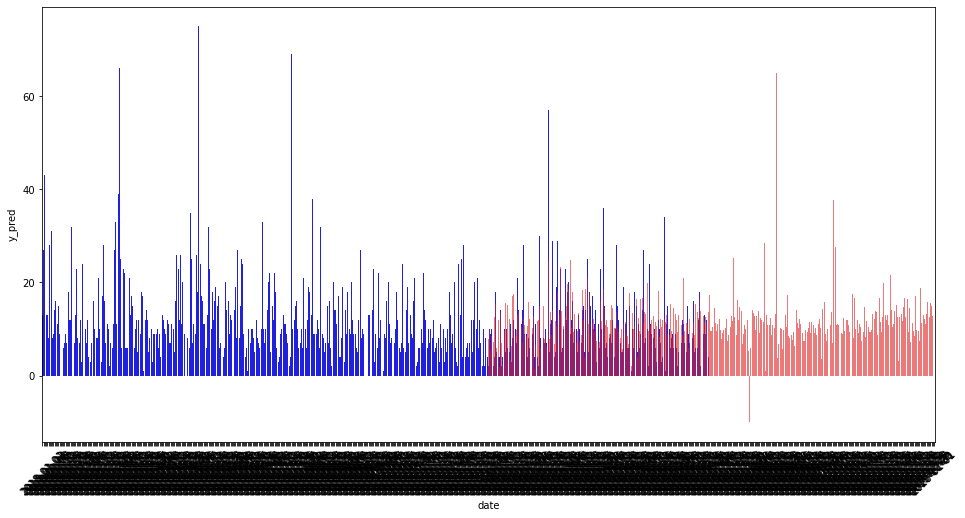

In [31]:
print_results()

### Ridge regression

In [32]:
# For documentation of SVR see: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR
ridge = GridSearchCV(Ridge(),
                     param_grid={"alpha": np.logspace(-5, -2, 4),   # The higher the value, the stronger the regularization
                                 "solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"]},
                     cv=5)
ridge.fit(X_train, y_train)
ridge.best_estimator_

Ridge(alpha=0.01, solver='lsqr')

RMSE for 01/2019 - 06/2019: 7.538238310298271


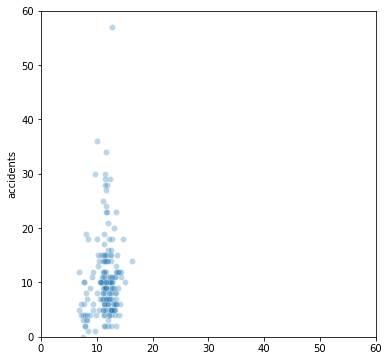

In [33]:
y_pred = ridge.predict(X_test)
y_pred2 = ridge.predict(X_test2)

print("RMSE for 01/2019 - 06/2019:", mean_squared_error(y_train[-181:], y_pred, squared=False))

fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=y_pred, y=y_test, alpha=0.3);
ax.set_xlim(0, 60);
ax.set_ylim(0, 60);

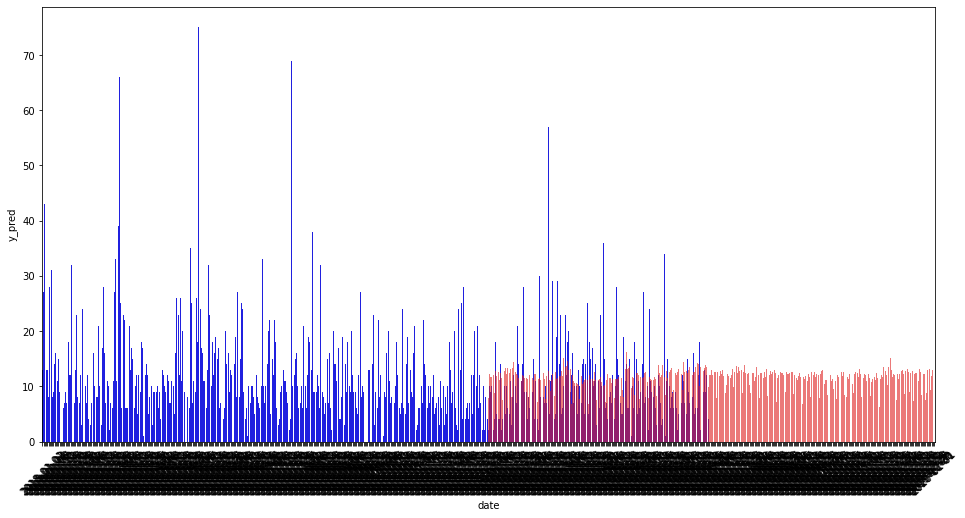

In [34]:
print_results()

### Support Vector Regression (SVR)

In [35]:
# For documentation of SVR see: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR
svr = GridSearchCV(SVR(kernel="rbf"),
                   param_grid={"C": np.logspace(0, 4, 5),
                               "epsilon": np.logspace(-4, -2, 3),
                               "gamma": ["scale", "auto"]},
                   cv=5)
svr.fit(X_train, y_train)
svr.best_estimator_

SVR(epsilon=0.01, gamma='auto')

RMSE for 01/2019 - 06/2019: 7.410229046065618


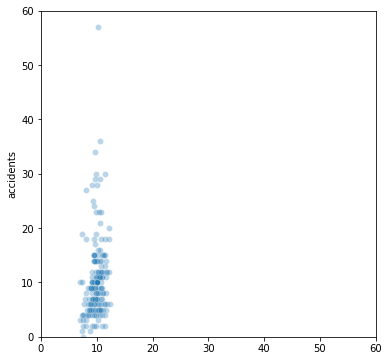

In [36]:
y_pred = svr.predict(X_test)
y_pred2 = svr.predict(X_test2)

print("RMSE for 01/2019 - 06/2019:", mean_squared_error(y_train[-181:], y_pred, squared=False))

fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=y_pred, y=y_test, alpha=0.3);
ax.set_xlim(0, 60);
ax.set_ylim(0, 60);

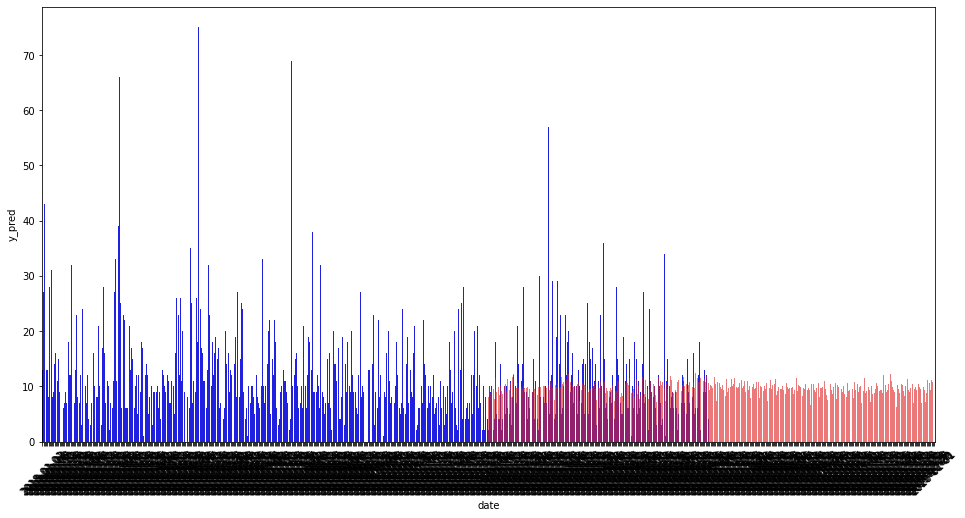

In [37]:
print_results()

### Stochastic Gradient Descent (SGD) - as recommended by machine-learning map

In [38]:
# For documentation of SGD see: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html
sgd = GridSearchCV(SGDRegressor(max_iter=20000,
                                early_stopping=False),
                   param_grid={"loss": ["squared_loss", "huber", "epsilon_insensitive", "squared_epsilon_insensitive"],
                               "penalty": ['l2', 'l1', 'elasticnet'],
                               "learning_rate": ["constant", "optimal", "invscaling", "adaptive"],
                               "alpha": np.logspace(-5, -2, 4),   # The higher the value, the stronger the regularization
                               "epsilon": np.logspace(-4, -2, 3)},
                   #scoring=?,
                   cv=5)

sgd.fit(X_train, y_train)
sgd.best_estimator_

SGDRegressor(alpha=0.001, epsilon=0.0001, learning_rate='optimal',
             loss='squared_epsilon_insensitive', max_iter=20000, penalty='l1')

RMSE for 01/2019 - 06/2019: 7.432334304839367


(0.0, 60.0)

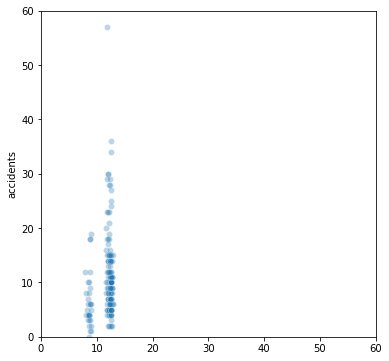

In [39]:
y_pred = sgd.predict(X_test)
y_pred2 = sgd.predict(X_test2)

print("RMSE for 01/2019 - 06/2019:", mean_squared_error(y_train[-181:], y_pred, squared=False))

fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=y_pred, y=y_test, alpha=0.3);
ax.set_xlim(0, 60)
ax.set_ylim(0, 60)

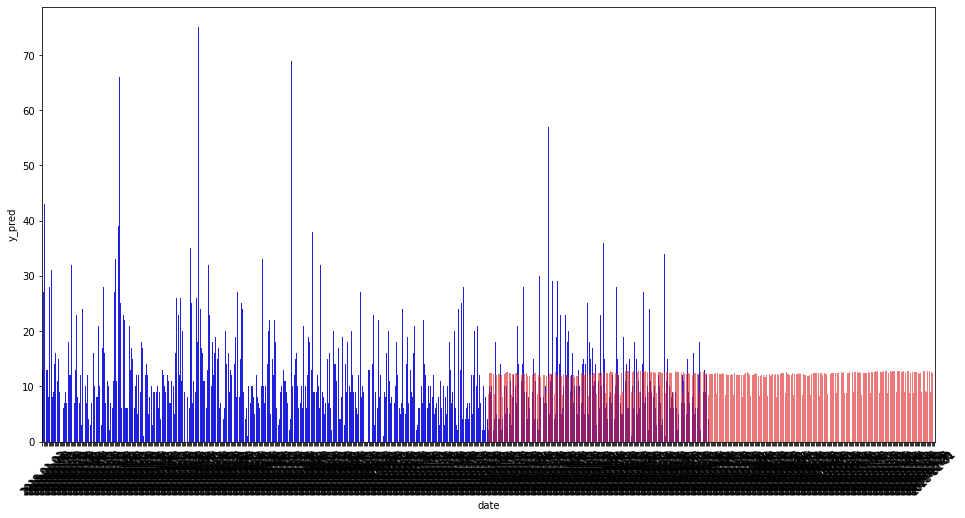

In [40]:
print_results()

Different regression algorithms were used to predict the road traffic accidents (RTAs). Best results are produced by the polynomial model. Interestingly, when ignoring the difference between standard work days (Monday to Saturday) and work free days (Sundays and holidays).

[Back to top](#Top)<br>

</br>
</br>
</br>

## Classifying in good and bad weather days <a name="Classifying_good_bad_weather"></a>

ToDo:
* Classification in god and bad weather
  * Creating holdoutset based on days (20%)
  * Creating time_window list with clusters/groups
  * Calculating metrics on accidents per time_window group (mean, median, mode)
  * Based on that setting threshold for god and bad weather days (bad leading to more accidents, good to less)
  * How to group time_windows on days?
  * Labeling days with "bad weather" and "good weather"

[Back to top](#Top)<br>